In [2]:
!pip install transformers

In [21]:
import os
import json
import torch
from transformers import BertTokenizer, BertForMaskedLM, AdamW
from torch.utils.data import Dataset, DataLoader

In [22]:
data_path = './project_data/preprocessed_data_no_stemming'

In [23]:
data = []
for filename in os.listdir(data_path):
    if filename.endswith(".json"):
        file_path = os.path.join(data_path, filename)

        with open(file_path, 'r') as file:
            try:
                file_content = json.load(file)
                data.append(file_content)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in {filename}: {e}")

In [24]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_data = tokenizer([entry["Text"] for entry in data], padding=True, truncation=True, return_tensors="pt")

In [40]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data

    def __len__(self):
        return len(self.tokenized_data["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.tokenized_data["input_ids"][idx],
            "attention_mask": self.tokenized_data["attention_mask"][idx],
        }

In [41]:
batch_size = 16
train_dataset = CustomDataset(tokenized_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [43]:
model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 25

In [46]:
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss}")

Epoch 1/25, Average Loss: 3.845113754272461
Epoch 2/25, Average Loss: 2.9096251726150513
Epoch 3/25, Average Loss: 2.4412770867347717
Epoch 4/25, Average Loss: 2.3451242446899414
Epoch 5/25, Average Loss: 2.15756893157959
Epoch 6/25, Average Loss: 2.0329882502555847
Epoch 7/25, Average Loss: 2.045157730579376
Epoch 8/25, Average Loss: 1.8188133239746094
Epoch 9/25, Average Loss: 1.7606770396232605
Epoch 10/25, Average Loss: 1.5147927179932594
Epoch 11/25, Average Loss: 1.5512704253196716
Epoch 12/25, Average Loss: 1.4545140266418457
Epoch 13/25, Average Loss: 1.3750309646129608
Epoch 14/25, Average Loss: 1.3124648332595825
Epoch 15/25, Average Loss: 1.2209280133247375
Epoch 16/25, Average Loss: 1.09537273645401
Epoch 17/25, Average Loss: 1.161871075630188
Epoch 18/25, Average Loss: 0.9983936548233032
Epoch 19/25, Average Loss: 0.9208071492612362
Epoch 20/25, Average Loss: 0.9834158420562744
Epoch 21/25, Average Loss: 0.905098021030426
Epoch 22/25, Average Loss: 0.8915821313858032
Epoch

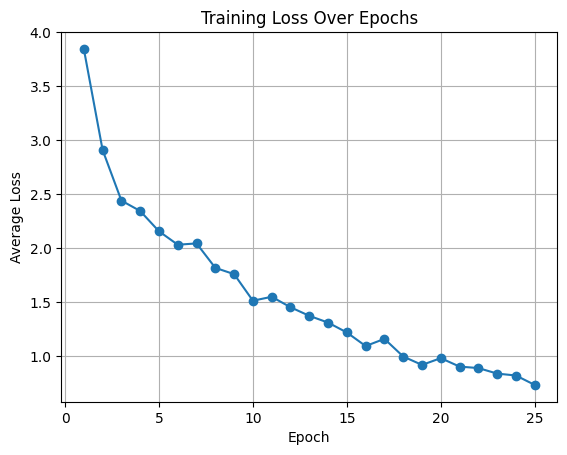

In [48]:
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [51]:
num_sentences = 5

for _ in range(num_sentences):
    prompt = "America is"  # You can choose a seed sentence
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # Generate a sequence of tokens
    with torch.no_grad():
        output = model.generate(input_ids, max_length=100, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95)

    # Decode the generated sequence and print the result
    generated_sentence = tokenizer.decode(output[0], skip_special_tokens=True)
    print("Generated Sentence:", generated_sentence)

Generated Sentence: america is europe ; asia oceania is africa oceania and australia ; africaesis is asia and oceania ; americas are americas and are continents and continents of the world ; tropical and temperate regions asia is temperate and tropical regions are tropicals and regions respectively, the continents are regions and polar regions. arctic is the arctic and the antarctic and arctic regions while tropical ; temperate region are temperate tropical tropical respectively respectively. temperate polar is polar and antarctic regions whereas arctic encompasses are the north and south polar arctic. africa arctic
Generated Sentence: america is europe ; oceania is asia ; and even africa is africa. somewhere else entirely... somewhere, somewhere in, someplace else... someplace entirely. someplace, wherever... somehow, even somewhere... wherever, perhaps even somehow... or, or even someplace... perhaps, entirely or altogether... anywhere else even - or somewhere - somewhere. or somepla